# Baseline Experiment - Santa 2025

This notebook establishes a baseline for the Christmas tree packing problem.

**Goal:** Create a valid submission with all 200 configurations (N=1 to 200) and calculate the score.

In [1]:
import numpy as np
import pandas as pd
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
from shapely.strtree import STRtree
import warnings
warnings.filterwarnings('ignore')

getcontext().prec = 30

# Tree geometry - 15 vertices
TX = [0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125]
TY = [0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5]

class ChristmasTree:
    def __init__(self, center_x=0, center_y=0, angle=0):
        self.center_x = float(center_x)
        self.center_y = float(center_y)
        self.angle = float(angle)
        
        # Create polygon
        initial_polygon = Polygon(list(zip(TX, TY)))
        rotated = affinity.rotate(initial_polygon, self.angle, origin=(0, 0))
        self.polygon = affinity.translate(rotated, xoff=self.center_x, yoff=self.center_y)

def has_overlap(trees):
    """Check if any trees overlap"""
    if len(trees) <= 1:
        return False
    
    polygons = [t.polygon for t in trees]
    tree_index = STRtree(polygons)
    
    for i, poly in enumerate(polygons):
        indices = tree_index.query(poly)
        for idx in indices:
            if idx != i:
                if poly.intersects(polygons[idx]) and not poly.touches(polygons[idx]):
                    return True
    return False

def get_bounding_box_side(trees):
    """Get the side length of the bounding square"""
    if not trees:
        return 0
    
    all_coords = []
    for tree in trees:
        coords = np.array(tree.polygon.exterior.coords)
        all_coords.append(coords)
    
    all_coords = np.vstack(all_coords)
    x_range = all_coords[:, 0].max() - all_coords[:, 0].min()
    y_range = all_coords[:, 1].max() - all_coords[:, 1].min()
    
    return max(x_range, y_range)

def get_score(trees, n):
    """Calculate score contribution for n trees"""
    side = get_bounding_box_side(trees)
    return side ** 2 / n

print("ChristmasTree class and utility functions defined.")
print(f"Tree has {len(TX)} vertices")

ChristmasTree class and utility functions defined.
Tree has 15 vertices


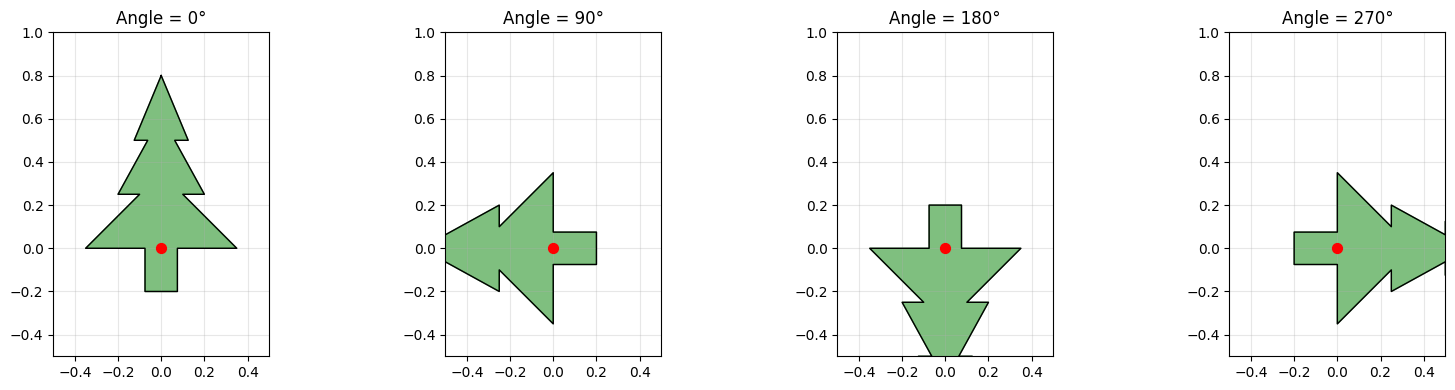

Tree width: 0.700
Tree height: 1.000


In [2]:
# Test the tree geometry
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, angle in enumerate([0, 90, 180, 270]):
    tree = ChristmasTree(0, 0, angle)
    x, y = tree.polygon.exterior.xy
    axes[i].fill(x, y, alpha=0.5, color='green')
    axes[i].plot(x, y, 'k-', linewidth=1)
    axes[i].scatter([0], [0], color='red', s=50, zorder=5)
    axes[i].set_aspect('equal')
    axes[i].set_title(f'Angle = {angle}°')
    axes[i].grid(True, alpha=0.3)
    axes[i].set_xlim(-0.5, 0.5)
    axes[i].set_ylim(-0.5, 1.0)

plt.tight_layout()
plt.savefig('/home/code/experiments/001_baseline/tree_geometry.png', dpi=100)
plt.show()

# Calculate tree dimensions
tree = ChristmasTree(0, 0, 0)
coords = np.array(tree.polygon.exterior.coords)
print(f"Tree width: {coords[:, 0].max() - coords[:, 0].min():.3f}")
print(f"Tree height: {coords[:, 1].max() - coords[:, 1].min():.3f}")

In [ ]:
# Simple greedy placement algorithm
# Place trees one by one, trying to minimize bounding box

def greedy_placement(n, angles=[0, 90, 180, 270]):
    """Place n trees using greedy algorithm"""
    if n == 1:
        # Single tree at origin with optimal rotation
        best_side = float('inf')
        best_angle = 0
        for angle in range(0, 360, 1):
            tree = ChristmasTree(0, 0, angle)
            side = get_bounding_box_side([tree])
            if side < best_side:
                best_side = side
                best_angle = angle
        return [ChristmasTree(0, 0, best_angle)]
    
    trees = []
    
    # Place first tree at origin
    trees.append(ChristmasTree(0, 0, 0))
    
    for tree_idx in range(1, n):
        best_placement = None
        best_score = float('inf')
        
        # Get current bounding box
        if trees:
            all_coords = np.vstack([np.array(t.polygon.exterior.coords) for t in trees])
            cx = (all_coords[:, 0].max() + all_coords[:, 0].min()) / 2
            cy = (all_coords[:, 1].max() + all_coords[:, 1].min()) / 2
            current_side = get_bounding_box_side(trees)
        else:
            cx, cy = 0, 0
            current_side = 0
        
        # Try different positions and angles
        for angle in angles:
            # Try positions around the current configuration
            for r in np.linspace(0.3, current_side + 1.5, 20):
                for theta in np.linspace(0, 2*np.pi, 16, endpoint=False):
                    x = cx + r * np.cos(theta)
                    y = cy + r * np.sin(theta)
                    
                    new_tree = ChristmasTree(x, y, angle)
                    test_trees = trees + [new_tree]
                    
                    if not has_overlap(test_trees):
                        side = get_bounding_box_side(test_trees)
                        if side < best_score:
                            best_score = side
                            best_placement = (x, y, angle)
        
        if best_placement is None:
            # Fallback: place far away
            for angle in angles:
                for offset in range(10, 100):
                    x = cx + offset * 0.5
                    y = cy
                    new_tree = ChristmasTree(x, y, angle)
                    test_trees = trees + [new_tree]
                    if not has_overlap(test_trees):
                        best_placement = (x, y, angle)
                        break
                if best_placement:
                    break
        
        if best_placement:
            trees.append(ChristmasTree(*best_placement))
        else:
            print(f"Warning: Could not place tree {tree_idx}")
            trees.append(ChristmasTree(tree_idx * 2, 0, 0))
    
    return trees

print("Greedy placement function defined.")

In [ ]:
# Test greedy placement for small N
test_n = 5
test_trees = greedy_placement(test_n)
print(f"Placed {len(test_trees)} trees")
print(f"Has overlap: {has_overlap(test_trees)}")
print(f"Bounding box side: {get_bounding_box_side(test_trees):.4f}")
print(f"Score contribution: {get_score(test_trees, test_n):.4f}")

# Visualize
fig, ax = plt.subplots(figsize=(8, 8))
colors = plt.cm.tab10(np.linspace(0, 1, test_n))

for i, tree in enumerate(test_trees):
    x, y = tree.polygon.exterior.xy
    ax.fill(x, y, alpha=0.5, color=colors[i], label=f'Tree {i}')
    ax.plot(x, y, 'k-', linewidth=0.5)
    ax.scatter([tree.center_x], [tree.center_y], color='red', s=20, zorder=5)

ax.set_aspect('equal')
ax.legend(loc='upper right')
ax.set_title(f'Greedy Placement for N={test_n}')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/experiments/001_baseline/greedy_test.png', dpi=100)
plt.show()

In [ ]:
# Generate all configurations from N=1 to N=200
# This will take some time

from tqdm import tqdm
import time

all_configurations = {}
all_scores = {}

start_time = time.time()

for n in tqdm(range(1, 201), desc="Generating configurations"):
    trees = greedy_placement(n)
    all_configurations[n] = trees
    
    # Validate
    if has_overlap(trees):
        print(f"Warning: N={n} has overlaps!")
    
    # Calculate score
    side = get_bounding_box_side(trees)
    score = side ** 2 / n
    all_scores[n] = {'side': side, 'score': score}

elapsed = time.time() - start_time
print(f"\nGeneration completed in {elapsed:.1f} seconds")

# Calculate total score
total_score = sum(s['score'] for s in all_scores.values())
print(f"\nTotal Score: {total_score:.6f}")
print(f"Target Score: 68.919154")
print(f"Gap: {total_score - 68.919154:.6f}")

In [ ]:
# Create submission CSV
def create_submission(configurations, output_path):
    """Create submission CSV from configurations"""
    rows = []
    
    for n in range(1, 201):
        trees = configurations[n]
        for i, tree in enumerate(trees):
            row = {
                'id': f'{n:03d}_{i}',
                'x': f's{tree.center_x}',
                'y': f's{tree.center_y}',
                'deg': f's{tree.angle}'
            }
            rows.append(row)
    
    df = pd.DataFrame(rows)
    df.to_csv(output_path, index=False)
    print(f"Submission saved to {output_path}")
    print(f"Total rows: {len(df)} (expected: 20100)")
    return df

submission_df = create_submission(all_configurations, '/home/submission/submission.csv')
print(submission_df.head(20))

In [ ]:
# Validate the submission
def validate_submission(file_path):
    """Validate submission file"""
    df = pd.read_csv(file_path)
    
    # Check row count
    expected_rows = sum(range(1, 201))
    print(f"Row count: {len(df)} (expected: {expected_rows})")
    
    # Check for all N values
    n_values = set()
    for idx, row in df.iterrows():
        n = int(row['id'].split('_')[0])
        n_values.add(n)
    
    missing_n = set(range(1, 201)) - n_values
    if missing_n:
        print(f"Missing N values: {missing_n}")
    else:
        print("All N values (1-200) present")
    
    # Check coordinate ranges
    def parse_coord(s):
        return float(str(s)[1:]) if str(s).startswith('s') else float(s)
    
    x_vals = df['x'].apply(parse_coord)
    y_vals = df['y'].apply(parse_coord)
    
    print(f"X range: [{x_vals.min():.4f}, {x_vals.max():.4f}]")
    print(f"Y range: [{y_vals.min():.4f}, {y_vals.max():.4f}]")
    
    if x_vals.min() < -100 or x_vals.max() > 100:
        print("WARNING: X coordinates out of range!")
    if y_vals.min() < -100 or y_vals.max() > 100:
        print("WARNING: Y coordinates out of range!")
    
    return True

validate_submission('/home/submission/submission.csv')

In [ ]:
# Score breakdown by N
print("Score breakdown (top 20 contributors):")
score_items = [(n, s['side'], s['score']) for n, s in all_scores.items()]
score_items.sort(key=lambda x: x[2], reverse=True)

for n, side, score in score_items[:20]:
    print(f"N={n:3d}: side={side:.4f}, score={score:.4f}")

print(f"\nTotal Score: {total_score:.6f}")

In [ ]:
# Save metrics
import json

metrics = {
    'total_score': total_score,
    'target_score': 68.919154,
    'gap': total_score - 68.919154,
    'n_scores': {str(n): s for n, s in all_scores.items()}
}

with open('/home/code/experiments/001_baseline/metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print("Metrics saved.")
print(f"\nFinal Score: {total_score:.6f}")